In [ ]:

from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rishikehs","key":"64905ed95cbc3e3d604c4be5f33cbed2"}'}

In [ ]:

!mkdir ~/.kaggle/

In [ ]:

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 99% 803M/812M [00:09<00:00, 61.4MB/s]
100% 812M/812M [00:09<00:00, 89.3MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq train.zip


**1.Consider the Cats & Dogs example. Start initially with a training sample of 1000, a
validation sample of 500, and a test sample of 500 (like in the text). Use any technique
to reduce overfitting and improve performance in developing a network that you train
from scratch. What performance did you achieve?**

Copying pictures to the test, validation, and training sets.

In [ ]:

import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

Convolutional neural networks are used.

In [ ]:

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

Given that the model may overfit, regularization techniques are employed at the DATA PREPROCESSING step.

Here, every image is transformed into a tensor.

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Callback can be either used for saveage the model's weights at the end of every epoch or for early stopping if the model is not improving. Besides that callbacks, such as logging metrics, visualizing the model performance, or scheduling a learning rate changes may be used in the same way.


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/30
63/63 [==============================] - 6s 96ms/step - loss: 0.6868 - accuracy: 0.5650 - val_loss: 0.6706 - val_accuracy: 0.5890
Epoch 2/30
63/63 [==============================] - 4s 57ms/step - loss: 0.6487 - accuracy: 0.6195 - val_loss: 0.6473 - val_accuracy: 0.6270
Epoch 3/30
63/63 [==============================] - 4s 56ms/step - loss: 0.5969 - accuracy: 0.6735 - val_loss: 0.6875 - val_accuracy: 0.6430
Epoch 4/30
63/63 [==============================] - 5s 72ms/step - loss: 0.5681 - accuracy: 0.6960 - val_loss: 0.6006 - val_accuracy: 0.6650
Epoch 5/30
63/63 [==============================] - 6s 84ms/step - loss: 0.5399 - accuracy: 0.7290 - val_loss: 0.6359 - val_accuracy: 0.6710
Epoch 6/30
63/63 [==============================] - 4s 57ms/step - loss: 0.5165 - accuracy: 0.7340 - val_loss: 0.5503 - val_accuracy: 0.7130
Epoch 7/30
63/63 [==============================] - 7s 103ms/step - loss: 0.4856 - accuracy: 0.7610 - val_loss: 0.6645 - val_accuracy: 0.6730
Epoch 8/30
6

Accuracy appears to be rising with the number of epochs.

Accuracy=71.3 Val_acc=70.4 test_acc=71.3

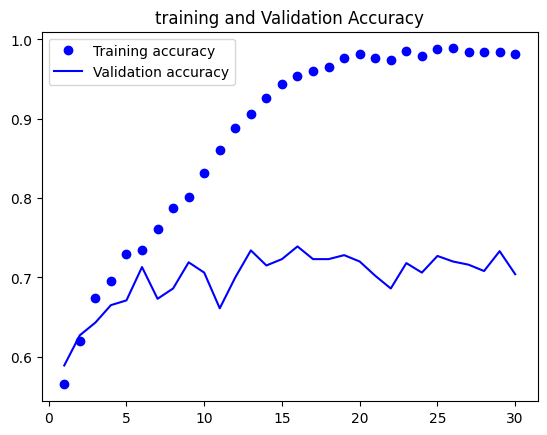

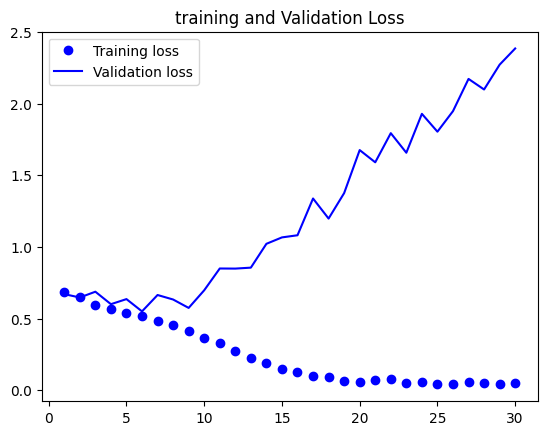

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("training and Validation Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("training and Validation Loss")
plt.legend()
plt.show()

In [ ]:


test_model = keras.models.load_model("convnet_from_scratch1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 28ms/step - loss: 0.5793 - accuracy: 0.7130
Test accuracy: 0.713


Test accuracy with no data augmentation=71.3

## **Data Augmentation**

Data augmentation acts like a master artist adding new custom made artwork to the training dataset by artfully modifying the original data. Apart from assisting in curbing overfitting, this aesthetic touch also leads to the development of a broader capability of recognizing more generalized cases by the model.


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/50
63/63 [==============================] - 9s 95ms/step - loss: 0.6988 - accuracy: 0.4785 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 5s 75ms/step - loss: 0.6943 - accuracy: 0.4995 - val_loss: 0.6945 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 6s 85ms/step - loss: 0.6910 - accuracy: 0.5060 - val_loss: 0.6892 - val_accuracy: 0.5060
Epoch 4/50
63/63 [==============================] - 6s 83ms/step - loss: 0.6906 - accuracy: 0.5220 - val_loss: 0.7301 - val_accuracy: 0.5060
Epoch 5/50
63/63 [==============================] - 4s 62ms/step - loss: 0.6798 - accuracy: 0.5685 - val_loss: 0.6874 - val_accuracy: 0.5610
Epoch 6/50
63/63 [==============================] - 6s 93ms/step - loss: 0.6610 - accuracy: 0.6140 - val_loss: 0.6823 - val_accuracy: 0.5960
Epoch 7/50
63/63 [==============================] - 4s 59ms/step - loss: 0.6469 - accuracy: 0.6415 - val_loss: 0.6739 - val_accuracy: 0.5570
Epoch 8/50
63

Displaying some randomly augmented training images:

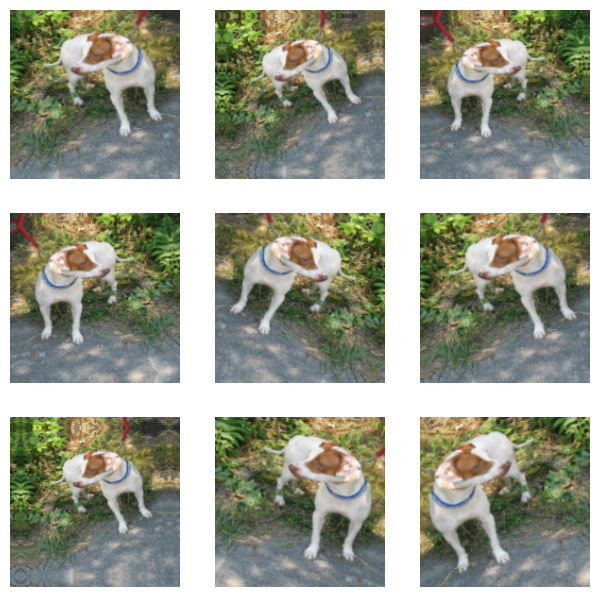

In [ ]:
plt.figure(figsize=(7.5,7.5 ))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**2. Increase your training sample size. You may pick any amount. Keep the validation and
test samples the same as above**


Tried to raise the 1000–1500 training sample size.

In [ ]:

import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=70,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/70
94/94 [==============================] - 9s 78ms/step - loss: 0.6923 - accuracy: 0.5333 - val_loss: 0.6743 - val_accuracy: 0.6030
Epoch 2/70
94/94 [==============================] - 7s 69ms/step - loss: 0.6699 - accuracy: 0.5987 - val_loss: 0.6458 - val_accuracy: 0.6170
Epoch 3/70
94/94 [==============================] - 5s 52ms/step - loss: 0.6373 - accuracy: 0.6497 - val_loss: 0.6106 - val_accuracy: 0.6660
Epoch 4/70
94/94 [==============================] - 8s 78ms/step - loss: 0.5955 - accuracy: 0.6760 - val_loss: 0.6422 - val_accuracy: 0.6440
Epoch 5/70
94/94 [==============================] - 5s 52ms/step - loss: 0.5593 - accuracy: 0.7253 - val_loss: 0.5859 - val_accuracy: 0.6870
Epoch 6/70
94/94 [==============================] - 7s 71ms/step - loss: 0.5061 - accuracy: 0.7483 - val_loss: 0.5383 - val_accuracy: 0.7240
Epoch 7/70
94/94 [==============================] - 6s 64ms/step - loss: 0.4537 - accuracy: 0.7900 - val_loss: 0.6176 - val_accuracy: 0.7080
Epoch 8/70
94

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 33ms/step - loss: 0.5028 - accuracy: 0.7580
Test accuracy: 0.758


Accuracy=75.8 val_acc=74.6 test_acc=75.8

## **Applying data augmentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=80,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/80
94/94 [==============================] - 6s 57ms/step - loss: 0.6896 - accuracy: 0.5243 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/80
94/94 [==============================] - 8s 81ms/step - loss: 0.6922 - accuracy: 0.5060 - val_loss: 0.6899 - val_accuracy: 0.5210
Epoch 3/80
94/94 [==============================] - 6s 56ms/step - loss: 0.6827 - accuracy: 0.5393 - val_loss: 0.6632 - val_accuracy: 0.6010
Epoch 4/80
94/94 [==============================] - 9s 93ms/step - loss: 0.6571 - accuracy: 0.6150 - val_loss: 0.6888 - val_accuracy: 0.6000
Epoch 5/80
94/94 [==============================] - 5s 55ms/step - loss: 0.6494 - accuracy: 0.6280 - val_loss: 0.6465 - val_accuracy: 0.6420
Epoch 6/80
94/94 [==============================] - 7s 68ms/step - loss: 0.6400 - accuracy: 0.6447 - val_loss: 0.6566 - val_accuracy: 0.6010
Epoch 7/80
94/94 [==============================] - 5s 53ms/step - loss: 0.6266 - accuracy: 0.6563 - val_loss: 0.6425 - val_accuracy: 0.6280
Epoch 8/80
94

Accuracy=93.8 val_acc=85.2 test_acc=84.8

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 36ms/step - loss: 0.3820 - accuracy: 0.8480
Test accuracy: 0.848


# **3. The objective is to find the ideal training sample size to get best prediction**

The sizes of the training, validation, and test sets were established at 1500, 1000, and 500, respectively.

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=90,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/90
94/94 [==============================] - 7s 72ms/step - loss: 0.6906 - accuracy: 0.5513 - val_loss: 0.6607 - val_accuracy: 0.6110
Epoch 2/90
94/94 [==============================] - 6s 61ms/step - loss: 0.6559 - accuracy: 0.6180 - val_loss: 0.6275 - val_accuracy: 0.6570
Epoch 3/90
94/94 [==============================] - 8s 78ms/step - loss: 0.6158 - accuracy: 0.6680 - val_loss: 0.5852 - val_accuracy: 0.6970
Epoch 4/90
94/94 [==============================] - 7s 67ms/step - loss: 0.5944 - accuracy: 0.6807 - val_loss: 0.6063 - val_accuracy: 0.6750
Epoch 5/90
94/94 [==============================] - 8s 84ms/step - loss: 0.5553 - accuracy: 0.7210 - val_loss: 0.5476 - val_accuracy: 0.7315
Epoch 6/90
94/94 [==============================] - 6s 61ms/step - loss: 0.5029 - accuracy: 0.7543 - val_loss: 0.5307 - val_accuracy: 0.7435
Epoch 7/90
94/94 [==============================] - 8s 80ms/step - loss: 0.4587 - accuracy: 0.7823 - val_loss: 0.7057 - val_accuracy: 0.6835
Epoch 8/90
94

In [ ]:

test_model = keras.models.load_model(
    "convnet_from_scratch3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


32/32 [==============================] - 1s 28ms/step - loss: 0.5366 - accuracy: 0.7520
Test accuracy: 0.752


Accuracy=99.3 val_Acc=75.0 test_Acc=75.2

# **Utilizing Augmented Data**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
94/94 [==============================] - 13s 107ms/step - loss: 0.6933 - accuracy: 0.5113 - val_loss: 0.6919 - val_accuracy: 0.5305
Epoch 2/100
94/94 [==============================] - 9s 94ms/step - loss: 0.6943 - accuracy: 0.5023 - val_loss: 0.6928 - val_accuracy: 0.5015
Epoch 3/100
94/94 [==============================] - 6s 62ms/step - loss: 0.6941 - accuracy: 0.5063 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 4/100
94/94 [==============================] - 7s 71ms/step - loss: 0.6935 - accuracy: 0.4967 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/100
94/94 [==============================] - 9s 92ms/step - loss: 0.6934 - accuracy: 0.4907 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/100
94/94 [==============================] - 6s 64ms/step - loss: 0.6933 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/100
94/94 [==============================] - 10s 104ms/step - loss: 0.6934 - accuracy: 0.4950 - val_loss: 0.6935 - val_accuracy: 0.5000
Ep

In [ ]:

test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


32/32 [==============================] - 1s 28ms/step - loss: 0.6919 - accuracy: 0.5240
Test accuracy: 0.524


Accuracy=48.9 val_acc=50.0 test_acc=52.4

# **4. Now using a pretrained network.**

This pre-trained network is modeled by VGG16.

Creating the VGG16 convolutional basis is the first step in feature extraction.

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

Extraction of features and associated labels is known as feature extraction.

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

train_features.shape


1/1 [==============================] - 2s 2s/step


(3000, 5, 5, 512)

The densely connected classifier is defined and trained throughout the feature extraction process.

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extractionPT1.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=15,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)


Epoch 1/15
94/94 [==============================] - 2s 10ms/step - loss: 19.6264 - accuracy: 0.9303 - val_loss: 4.0696 - val_accuracy: 0.9705
Epoch 2/15
94/94 [==============================] - 0s 5ms/step - loss: 3.1697 - accuracy: 0.9747 - val_loss: 8.7676 - val_accuracy: 0.9595
Epoch 3/15
94/94 [==============================] - 0s 5ms/step - loss: 1.6974 - accuracy: 0.9870 - val_loss: 4.6360 - val_accuracy: 0.9735
Epoch 4/15
94/94 [==============================] - 0s 5ms/step - loss: 0.9081 - accuracy: 0.9920 - val_loss: 5.7779 - val_accuracy: 0.9685
Epoch 5/15
94/94 [==============================] - 0s 5ms/step - loss: 0.4778 - accuracy: 0.9940 - val_loss: 5.2675 - val_accuracy: 0.9720
Epoch 6/15
94/94 [==============================] - 1s 8ms/step - loss: 1.3842 - accuracy: 0.9903 - val_loss: 7.0084 - val_accuracy: 0.9670
Epoch 7/15
94/94 [==============================] - 1s 8ms/step - loss: 0.5023 - accuracy: 0.9963 - val_loss: 5.0084 - val_accuracy: 0.9755
Epoch 8/15
94/94 [

accuracy=99.7 val_acc=97.5

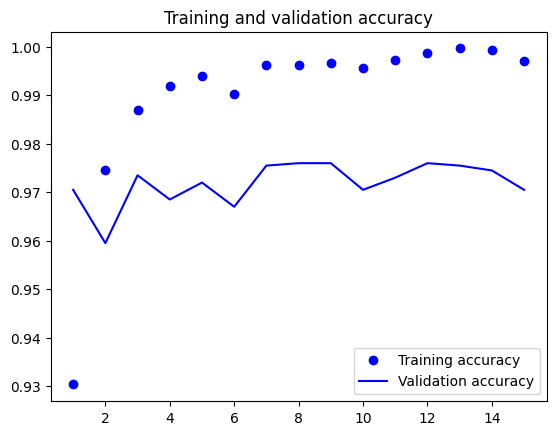

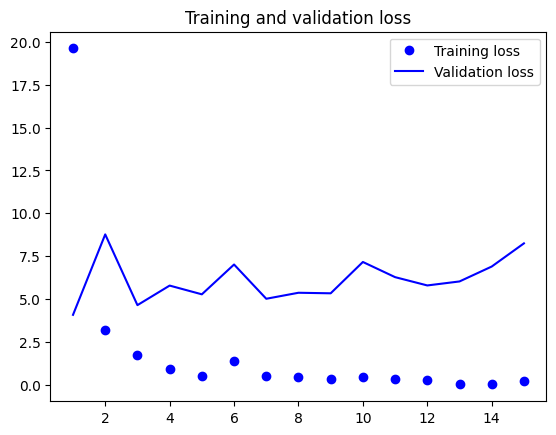

In [ ]:

import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False


conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))


conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


# **Utilizing data augmentation for feature extraction**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentationPT2.keras",
        save_best_only=True,
        monitor="val_loss",
        save_weights_only=True)
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
94/94 [==============================] - 16s 171ms/step - loss: 1.3165 - accuracy: 0.9757 - val_loss: 2.4174 - val_accuracy: 0.9755
Epoch 2/30
94/94 [==============================] - 17s 174ms/step - loss: 1.7702 - accuracy: 0.9730 - val_loss: 2.3514 - val_accuracy: 0.9745
Epoch 3/30
94/94 [==============================] - 16s 171ms/step - loss: 1.4329 - accuracy: 0.9743 - val_loss: 1.9583 - val_accuracy: 0.9805
Epoch 4/30
94/94 [==============================] - 16s 166ms/step - loss: 1.3123 - accuracy: 0.9777 - val_loss: 3.1725 - val_accuracy: 0.9620
Epoch 5/30
94/94 [==============================] - 16s 167ms/step - loss: 1.0921 - accuracy: 0.9760 - val_loss: 1.7295 - val_accuracy: 0.9775
Epoch 6/30
94/94 [==============================] - 20s 213ms/step - loss: 0.9200 - accuracy: 0.9823 - val_loss: 1.6811 - val_accuracy: 0.9750
Epoch 7/30
94/94 [==============================] - 16s 166ms/step - loss: 0.9962 - accuracy: 0.9790 - val_loss: 2.0486 - val_accuracy: 0.9695

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentationPT2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 89ms/step - loss: 4.2593 - accuracy: 0.9690 Test accuracy: 0.969 accuracy=96.9% val_Acc=97.4% test_acc=97.4%